# High-dimensional Filtering on a Gaussian linear model

In this notebook we study how important the proposal is when the dimension of the latent variable grows and how to approximate the optimal proposal when it is intractable.


We base this study on a simple example : a linear Gaussian hidden Markov model consisting of a linear Gaussian latent process and a Gaussian observation process :

$$ x_t|x_{t-1} \sim \mathcal{N}(0.5x_{t-1}, \Sigma)$$

$$ y_t | x_t \sim  \mathcal{N}(x_{t}, \sigma_y^2) $$

In [1]:
library(MASS) # for multivariate Gaussian simulation : function mvrnorm
library(RSQMC) # homemade Rcpp package for internal filter functions
library(profvis) # R profiler
library(parallel) # parallel computing for backward simulations

library(ggplot2) # plotting library

source(file.path(getwd() ,"Linear_Gaussian_Model_Functions.R"))

# for reproducibility
set.seed(41)

### Parameters

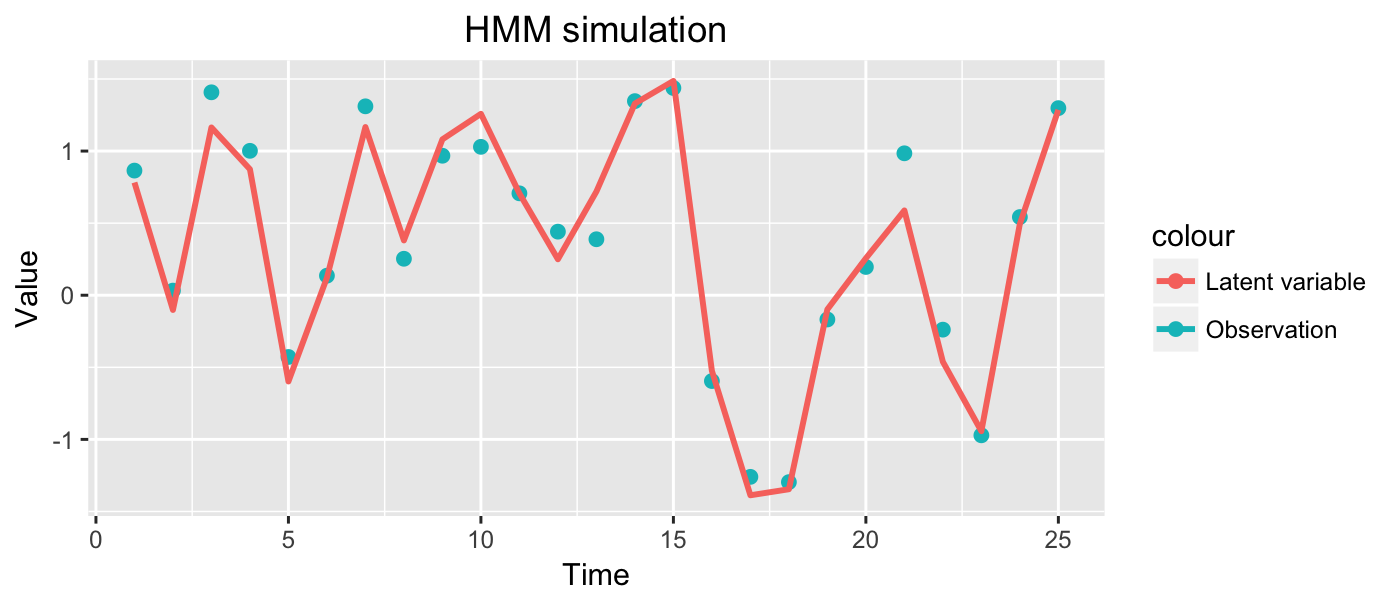

In [2]:
T_ <- 25 # time
D <- 512 # dimension of x
sigma_y <- .25**2 # variance of y|x
M <- 32 # number of internal particles
N <- 100 # number of external particles
tau <- 1. # coordinates variance
lambda <- 1. # coordinates correlation

# Covariance matrix 
S = covariance_matrix(D, tau, lambda)

# State-space model
SSM = state_space_model(D, T_, S, sigma_y)
x = SSM$X
y = SSM$Y

# Latent variable and observation plot
df = data.frame(x = x[1, ], y= y[1,])
df$idu <- as.numeric(row.names(df))
options(repr.plot.height=3, repr.plot.res = 200)
(ggplot(df) + geom_point(aes(x=idu, y=y, color='Observation'), size=2)+ 
 geom_line(aes(x=idu, y=x, color='Latent variable'), size=1) + 
 xlab('Time') + ylab('Value') + labs(title='HMM simulation') + 
 theme(plot.title = element_text(hjust = 0.5)) )

## NSMC

We compare Nested Sequential Monte Carlo as described in $\textit{High-dimensional Filtering using Nested Sequential Monte Carlo}$ by $\textit{Naesseth & al.}$ on a simple Gaussian linear model with and without QMC.

NSMC is designed to perform Sequential Monte Carlo on particular high dimensional models in which the optimal proposal is not necessarly tractable. 

It exploits the local dependencies of the state-space variable to simulate exact approximation of the optimal proposal.

We run each filter several times to compute empirical variance of the resulting estimators.

### Comparison of NSMC with and without QMC 

In [3]:
nb_filters <- 10 # number of time each filter is run 

MAP_without_QMC <- array(0, dim=c(nb_filters, D, T_))
MAP_with_QMC <- array(0, dim=c(nb_filters, D, T_))

particles <- array(0, dim=c(N, D, T_+1))
particles_QMC <- array(0, dim=c(N, D, T_+1))

for(f in 1:nb_filters){
    particles <- NSMC_linear_gaussian(y, N, M, D, T_, S, sigma_y, QMC=FALSE)
    MAP_without_QMC[f, , ] <- apply(particles, c(2,3), mean)
    
    particles_QMC <- NSMC_linear_gaussian(y, N, M, D, T_, S, sigma_y, QMC=TRUE)
    MAP_with_QMC[f, , ] <- apply(particles_QMC, c(2,3), mean)
}

#### Latent variable estimation

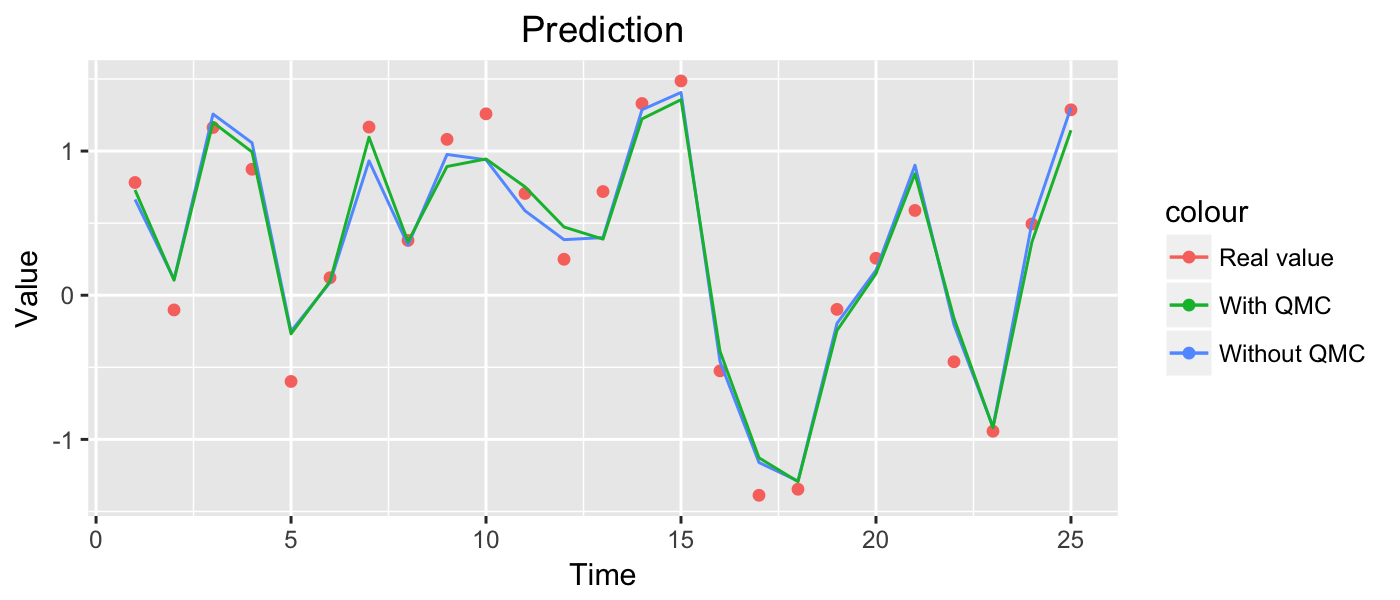

In [4]:
plot_coordinate = 1
df = data.frame(real_value = x[plot_coordinate, ], 
                no_QMC = MAP_without_QMC[1, plot_coordinate, ], 
                QMC = MAP_with_QMC[1, plot_coordinate, ])

df$idu <- as.numeric(row.names(df))

prediction_plot <- (ggplot(df) + geom_point(aes(x=idu, y=real_value, color='Real value')) + 
 geom_line(aes(x=idu, y=no_QMC, color='Without QMC')) + 
 geom_line(aes(x=idu, y=QMC, color='With QMC'))+ 
 labs(title='Prediction') + 
 xlab('Time') + ylab('Value') +
 theme(plot.title = element_text(hjust = 0.5)))

savename <- paste('plots/prediction/prediction_plot_', D,'_', N, '_', M, '.pdf', sep="")
ggsave(filename=savename, plot=prediction_plot, height=5,width=12,dpi=72)

prediction_plot

#### Variance

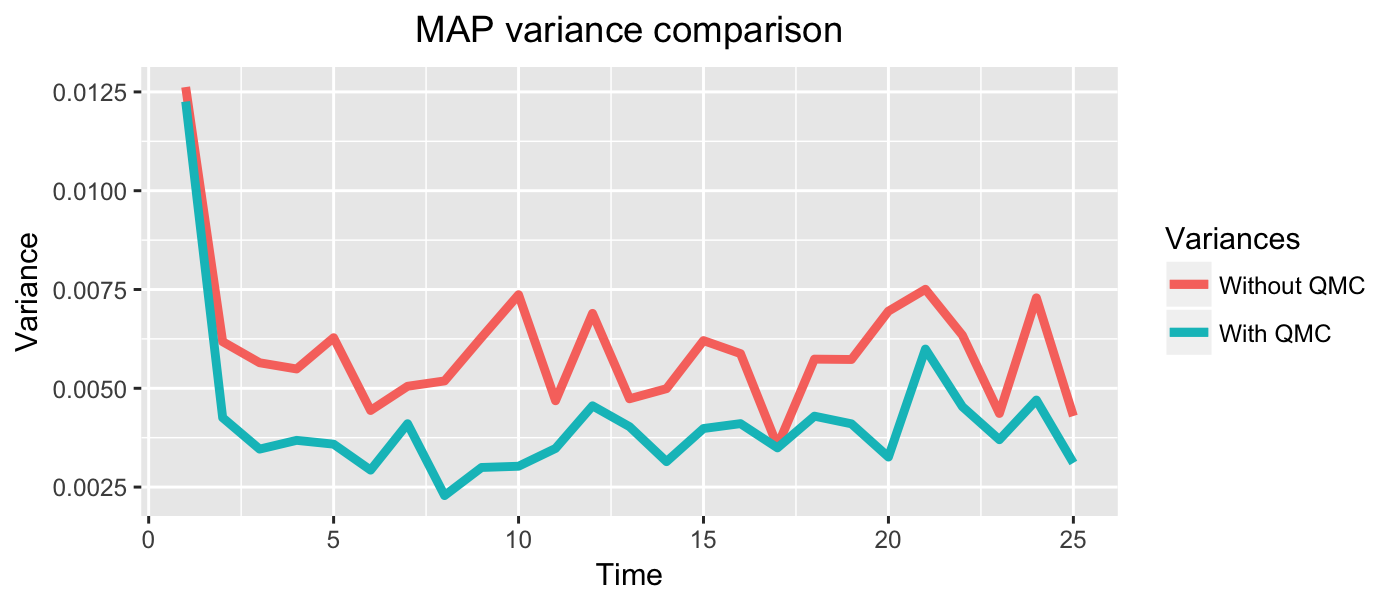

In [5]:
var = apply(MAP_without_QMC[ , , ], c(2, 3), var)

var_QMC = apply(MAP_with_QMC[ , ,], c(2, 3), var)

vars = data.frame(var = apply(var, 2, mean), var_QMC = apply(var_QMC, 2, mean))

variance_plot <- (ggplot(vars) + geom_line(aes(x=1:T_, y=var, colour='blue'), size=1.5) + 
 geom_line(aes(x=1:T_, y=var_QMC, colour='green'), size=1.5) + 
 labs(title='MAP variance comparison') +
 scale_color_discrete(name = "Variances", labels = c("Without QMC", "With QMC")) +
 xlab('Time') + ylab('Variance') + 
 theme(plot.title = element_text(hjust = 0.5)))

savename <- paste('plots/variance/variance_plot_', D,'_', N, '_', M, '.pdf', sep="")
ggsave(filename=savename, plot=variance_plot, height=9, width=12, dpi=72)
variance_plot

# SMC proposal comparison

We run two particle filters : a "naive" particle filter (by taking as proposal the transition kernel : bootstrap PF) and a "guided" particle filter (by taking into account the observation in the proposal) to show that SMC struggle in high dimension without a good proposal.

In [3]:
library(mvtnorm) # for multivariate Gaussian density
number_of_particles <- N*M # for fair comparison between SMC and NSMC

In [ ]:
## Bootstrap particle filter ##
pred_naive <- array(0, dim=c(D, T_))
pred_naive <- gaussian_bootstrap_filter(y, sigma_y, D, T_, S, number_of_particles)

## Guided particle filter (optimal proposal) ##
pred_optimal <- array(0, dim=c(D, T_))
pred_optimal <- gaussian_guided_filter(y, sigma_y, D, T_, S, number_of_particles)

plot_coordinate = 1

df_proposal_comparison = data.frame(real_value = x[plot_coordinate, ], 
                                    naive = pred_naive[plot_coordinate, ], 
                                    optimal = pred_optimal[plot_coordinate, ])


plot_title =  bquote(Estimation ~ of ~ one ~ coordinate ~ of ~ the ~ latent ~ variable ~"("*n[x] == .(D)*")")
plot_proposal_comparison <- (ggplot(df_proposal_comparison) + 
               geom_line(aes(x=1:T_, y=real_value, colour='Real value'), size=0.8) + 
               geom_line(aes(x=1:T_, y=optimal, colour='Optimal proposal'), size=0.5) + 
               geom_line(aes(x=1:T_, y=naive, colour='Bootstrap proposal'), size=0.5) +
                             labs(color="")+
               xlab('Time') + ylab('Value'))

savename <- paste('plots/proposal/proposal_plot_', D,'_', N, '_', M, '.pdf', sep="")
ggsave(filename=savename, plot=plot_proposal_comparison, height=5,width=7,dpi=72)

plot_proposal_comparison  + labs(title=plot_title)